# 2 Модель Inception v3 с датасетом EMNIST

In [1]:
! pip install torch-summary -q

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary

In [3]:
def evaluate_accuracy(data_iter, net):
    '''
    Функция подсчета метрики accuracy.
    '''
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        # acc_sum += (net(X).logits.argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [4]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            # y_hat = net(X).logits
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 50 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка данных

In [6]:
BATCH_SIZE = 256
# transoforms = tv.transforms.Compose([
#     tv.transforms.Grayscale(3),
#     tv.transforms.Resize((224, 224)),
#     tv.transforms.ToTensor()
# ])

# transforms = tv.transforms.Compose([
#     tv.transforms.Resize(299),
#     tv.transforms.CenterCrop(299),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# transforms = tv.transforms.Compose([
#     tv.transforms.Resize(256),  # Resize the image to 256x256 pixels
#     tv.transforms.CenterCrop(224),  # Crop the center 224x224 pixels
#     tv.transforms.ToTensor(),  # Convert the image to a tensor
#     # Normalize with ImageNet mean and std
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 562M/562M [00:09<00:00, 60.4MB/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [7]:
test_dataset[0][0].shape

torch.Size([3, 299, 299])

In [8]:
# dataiter = iter(train_iter)

In [9]:
dataiter = iter(train_dataset)

In [10]:
classes = train_dataset.classes

Размер изображения torch.Size([299, 299])
r


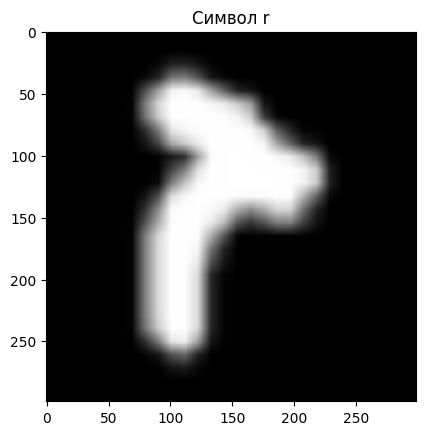

In [11]:
data = next(dataiter)
features, labels = data
print('Размер изображения', features[0].shape)
label = classes[labels]
print(label)
plt.imshow(torch.squeeze(features[0]), cmap = 'gray')
# plt.title('Класс '+ str(labels[0].item()))
plt.title('Символ ' + str(label))
plt.show()

In [12]:
dataiter = iter(train_iter)
data = next(dataiter)
features, labels = data
print('Количество классов:', len(torch.unique(labels)))
print('Классы:', torch.unique(labels))
print('Индексы и классы:', train_dataset.class_to_idx)
print('Классы', train_dataset.classes)

Количество классов: 47
Классы: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])
Индексы и классы: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a': 36, 'b': 37, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'n': 43, 'q': 44, 'r': 45, 't': 46}
Классы ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [13]:
# model = tv.models.inception_v3(pretrained=True)
# model = tv.models.inception_v3(pretrained=True, aux_logits=False)
# model = tv.models.inception_v3(pretrained=False, aux_logits=False)
model = tv.models.inception_v3(weights=None, aux_logits=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [14]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [16]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [17]:
# меняем последний слой
model.fc = nn.Linear(in_features=2048, out_features=47)

In [18]:
# Собираем параметры для обучения
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [19]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [20]:
train(model, train_iter, test_iter, trainer, 3)

Step 0. time since epoch: 2.783. Train acc: 0.023. Train Loss: 3.882
Step 50. time since epoch: 99.999. Train acc: 0.055. Train Loss: 3.732
Step 100. time since epoch: 199.249. Train acc: 0.086. Train Loss: 3.605
Step 150. time since epoch: 299.444. Train acc: 0.111. Train Loss: 3.504
Step 200. time since epoch: 400.054. Train acc: 0.131. Train Loss: 3.419
Step 250. time since epoch: 500.701. Train acc: 0.148. Train Loss: 3.349
Step 300. time since epoch: 601.542. Train acc: 0.162. Train Loss: 3.288
Step 350. time since epoch: 702.287. Train acc: 0.175. Train Loss: 3.234
Step 400. time since epoch: 803.368. Train acc: 0.188. Train Loss: 3.184
--------------------
epoch 1, loss 3.1499, train acc 0.195, test acc 0.386, time 964.4 sec
Step 0. time since epoch: 1.731. Train acc: 0.395. Train Loss: 2.618
Step 50. time since epoch: 93.907. Train acc: 0.390. Train Loss: 2.576
Step 100. time since epoch: 182.524. Train acc: 0.398. Train Loss: 2.549
Step 150. time since epoch: 271.167. Train ac

In [26]:
data = {
    'Модель': ['Inception v3', 'Inception v3', 'Inception v3'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.386, 0.494, 0.546],
    'Test_loss': [3.1499, 2.3305, 1.9375]
}
inception = pd.DataFrame(data)
print(inception)

         Модель  Номер эпохи  Test_acc  Test_loss
0  Inception v3            1     0.386     3.1499
1  Inception v3            2     0.494     2.3305
2  Inception v3            3     0.546     1.9375


In [23]:
data = {
    'Модель': ['ResNet18', 'ResNet18', 'ResNet18'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.780, 0.79, 0.798],
    'Test_loss': [0.7891, 0.6813, 0.6304]
}
res = pd.DataFrame(data)
print(res)

     Модель  Номер эпохи  Test_acc  Test_loss
0  ResNet18            1     0.780     0.7891
1  ResNet18            2     0.790     0.6813
2  ResNet18            3     0.798     0.6304


In [24]:
data = {
    'Модель': ['VGG16', 'VGG16', 'VGG16'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.499, 0.579, 0.622],
    'Test_loss': [3.2006, 2.3234, 1.8065]
}
res_vgg_16 = pd.DataFrame(data)
print(res_vgg_16)

  Модель  Номер эпохи  Test_acc  Test_loss
0  VGG16            1     0.499     3.2006
1  VGG16            2     0.579     2.3234
2  VGG16            3     0.622     1.8065


In [25]:
res = pd.concat([res, res_vgg_16], ignore_index=True)
print(res)

     Модель  Номер эпохи  Test_acc  Test_loss
0  ResNet18            1     0.780     0.7891
1  ResNet18            2     0.790     0.6813
2  ResNet18            3     0.798     0.6304
3     VGG16            1     0.499     3.2006
4     VGG16            2     0.579     2.3234
5     VGG16            3     0.622     1.8065


In [27]:
res = pd.concat([res, inception], ignore_index=True)
print(res)

         Модель  Номер эпохи  Test_acc  Test_loss
0      ResNet18            1     0.780     0.7891
1      ResNet18            2     0.790     0.6813
2      ResNet18            3     0.798     0.6304
3         VGG16            1     0.499     3.2006
4         VGG16            2     0.579     2.3234
5         VGG16            3     0.622     1.8065
6  Inception v3            1     0.386     3.1499
7  Inception v3            2     0.494     2.3305
8  Inception v3            3     0.546     1.9375
